In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import json
import sys
# setting path
sys.path.append('../common')
import utils

SETUP_PATH = 'setup.json'
f = open(SETUP_PATH)
data = json.load(f)

In [18]:
# Initialize database
import requests
import datetime

clear_url = data['app']['clearUrl']
print(clear_url)
response = requests.post(clear_url)
print(response.content)
print(response.status_code)

fill_in_url = data['app']['fillInUrl']
N = data['fill_in_quantity']
print(fill_in_url)
print(N)
patch = 10000
iterations = int(N / patch)
print(iterations)
for i in range(1, iterations):
    first_time = datetime.datetime.now()
    response = requests.post(fill_in_url, params={'N': patch})
    later_time = datetime.datetime.now()
    difference = later_time - first_time
    print(f'{i}/{iterations}: {response.content}')
    print(f'{i}/{iterations}: {response.status_code}')
    print(f'{i}/{iterations}: duration: {utils.durationToString(difference.seconds)}')
    remaining_iterations = iterations - i
    print(f'{i}/{iterations}: expected end in: {utils.durationToString(difference.seconds * remaining_iterations)}')

patch = N % patch
if patch > 0:
    response = requests.post(fill_in_url, params={'N': patch})
    print(response.content)
    print(response.status_code)

http://localhost:8000/blogs/clear/


b'{"Count of Blogs":0}'
200
http://localhost:8000/blogs/fill_in/
100000
10
1/10: b'{"Count of Blogs":10000}'
1/10: 200
1/10: duration: 29s
1/10: expected end in: 4m 21s
2/10: b'{"Count of Blogs":20000}'
2/10: 200
2/10: duration: 28s
2/10: expected end in: 3m 44s
3/10: b'{"Count of Blogs":30000}'
3/10: 200
3/10: duration: 28s
3/10: expected end in: 3m 16s
4/10: b'{"Count of Blogs":40000}'
4/10: 200
4/10: duration: 28s
4/10: expected end in: 2m 48s
5/10: b'{"Count of Blogs":50000}'
5/10: 200
5/10: duration: 28s
5/10: expected end in: 2m 20s
6/10: b'{"Count of Blogs":60000}'
6/10: 200
6/10: duration: 30s
6/10: expected end in: 2m
7/10: b'{"Count of Blogs":70000}'
7/10: 200
7/10: duration: 49s
7/10: expected end in: 2m 27s
8/10: b'{"Count of Blogs":80000}'
8/10: 200
8/10: duration: 48s
8/10: expected end in: 1m 36s
9/10: b'{"Count of Blogs":90000}'
9/10: 200
9/10: duration: 50s
9/10: expected end in: 50s


In [19]:
def run_k6(app: dict, script_path: str, vus: int, dir_name):
    !k6 run {script_path} \
        --env vus={vus} \
        --env url={app["url"]} \
        --out json={dir_name}/{app["name"]}.json \
        --out csv={dir_name}/{app["name"]}.csv

## Run k6 test script

In [21]:
import os
import shutil
from datetime import datetime
import math 



# prepare directory structure
if not os.path.exists(data["test_result_base_dir"]):
    os.makedirs(data["test_result_base_dir"])

dt_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
print("date and time =", dt_string)

dir_name = f'./{data["test_result_base_dir"]}/{data["test_result_dir_prefix"]}{dt_string}'
print(dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
# copy script
shutil.copy(data["script_path"], dir_name)
shutil.copy(SETUP_PATH, dir_name)

out_file_name = "out-fill-in.txt"
out_file = open(out_file_name, "a")
out_file.write(f'\n-------------------------')
out_file.close()

vus = 2048 # initial value
beg = 1
end = None
threshold = 0
while (True):
    # run test
    run_k6(data["app"], script_path=data["script_path"], vus=vus, dir_name=dir_name)

    # load dataframe
    dir = utils.get_last_result_dir(setup_data=data)
    path = f'./{dir}/{data["app"]["name"]}.csv'
    df = pd.read_csv(path)

    # calculate metric
    incorrect_part = utils.get_incorrect_part(df)
        
    print(f'Incorrect part for vus = {vus}: {incorrect_part}\n')

    out_file = open(out_file_name, "a")
    out_file.write(f'\nvus = {vus}, beg = {beg}, end = {end}, incorrect_part = {incorrect_part}')
    out_file.close()

    if (incorrect_part > threshold):
        end = vus
        vus = math.floor((end + beg) / 2)
    else:
        beg = vus
        vus = vus * 2 if end == None else math.floor((end + beg) / 2)
    
    if end and end - beg < 2:
        break
        


date and time = 2023-11-04_17-02-29
./out/out_2023-11-04_17-02-29

          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_17-02-29/django.json), csv (./out/out_2023-11-04_17-02-29/django.csv)

  scenarios: (100.00%) 1 scenario, 2048 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 2048 looping VUs for 30s (gracefulStop: 30s)


Init      [===>----------------------------------] 0251/2048 VUs initialized
default   [--------------------------------------]

Init      [=========>----------------------------] 0567/2048 VUs initialized
default   [--------------------------------------]

Init      [=============>------------------------] 0800/2048 VUs initialized
default   [--------------------------------------]

Init      [=============

/tmp/ipykernel_234932/839792683.py:40: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Incorrect part for vus = 4096: 0.5727604377786786


          /\      |‾‾| /‾‾/   /‾‾/   
     /\  /  \     |  |/  /   /  /    
    /  \/    \    |     (   /   ‾‾\  
   /          \   |  |\  \ |  (‾)  | 
  / __________ \  |__| \__\ \_____/ .io

  execution: local
     script: ../../grafana-k6/script.js
     output: json (./out/out_2023-11-04_17-02-29/django.json), csv (./out/out_2023-11-04_17-02-29/django.csv)

  scenarios: (100.00%) 1 scenario, 3072 max VUs, 1m0s max duration (incl. graceful stop):
           * default: 3072 looping VUs for 30s (gracefulStop: 30s)


Init      [>-------------------------------------] 0106/3072 VUs initialized
default   [--------------------------------------]

Init      [===>----------------------------------] 0348/3072 VUs initialized
default   [--------------------------------------]

Init      [====>---------------------------------] 0468/3072 VUs initialized
default   [--------------------------------------]

Init      [=======>--------------------

## Smoke Processing data

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np

In [23]:
import sys
# setting path
sys.path.append('../common')
import utils


dir = utils.get_last_result_dir(setup_data=data)
print(dir)
path = f'.{data["test_result_base_dir"]}/{dir}/django.json'
print(path)
df = pd.read_csv(f'{dir}/django.csv')


out/out_2023-11-04_17-02-29
.out/out/out_2023-11-04_17-02-29/django.json


In [24]:
path = f'./{dir}/{data["app"]["name"]}.csv'
df = pd.read_csv(path)

In [25]:
df.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
0,vus,1699114574,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,vus_max,1699114574,1350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,vus,1699114575,810.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vus_max,1699114575,3123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,vus,1699114576,2973.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21300 entries, 0 to 21299
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   metric_name        21300 non-null  object 
 1   timestamp          21300 non-null  int64  
 2   metric_value       21300 non-null  float64
 3   check              0 non-null      float64
 4   error              0 non-null      float64
 5   error_code         0 non-null      float64
 6   expected_response  12258 non-null  object 
 7   group              0 non-null      float64
 8   method             12258 non-null  object 
 9   name               12258 non-null  object 
 10  proto              12258 non-null  object 
 11  scenario           21176 non-null  object 
 12  service            0 non-null      float64
 13  status             12258 non-null  float64
 14  subproto           0 non-null      float64
 15  tls_version        0 non-null      float64
 16  url                122

In [27]:
df['metric_name'].unique()

array(['vus', 'vus_max', 'http_reqs', 'http_req_duration',
       'http_req_blocked', 'http_req_connecting',
       'http_req_tls_handshaking', 'http_req_sending', 'http_req_waiting',
       'http_req_receiving', 'http_req_failed', 'data_sent',
       'data_received', 'iteration_duration', 'iterations'], dtype=object)

[Text(0, 0, '62'),
 Text(0, 0, '62'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '1362'),
 Text(0, 0, '3141'),
 Text(0, 0, '3141'),
 Text(0, 0, '1318'),
 Text(0, 0, '1318')]

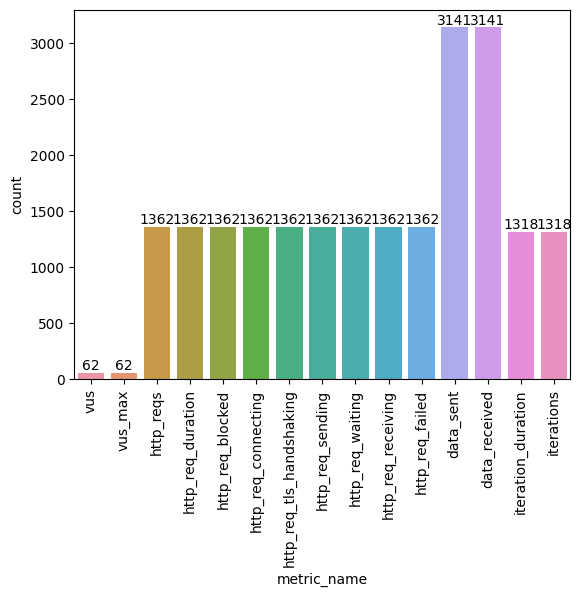

In [28]:
chart = sns.countplot(data=df, x='metric_name')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
chart.bar_label(chart.containers[0])


In [29]:
df.shape

(21300, 19)

In [30]:
df_1 = df.loc[(df['metric_name'] == 'http_req_duration')]
df_1.shape


(1362, 19)

In [31]:
df_1.head()

,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
61,http_req_duration,1699114603,28514.809956,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
70,http_req_duration,1699114603,28362.431012,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
79,http_req_duration,1699114603,28385.177408,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
88,http_req_duration,1699114603,28406.079816,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
97,http_req_duration,1699114603,28406.786558,NaN,NaN,NaN,True,NaN,GET,http://localhost:8000/collisions/,HTTP/1.1,default,NaN,200.0,NaN,NaN,http://localhost:8000/collisions/,NaN,NaN
